# Estadística aplicada
Andrea Carolina López Ruiz #M:1902969<br>
José Alfonso González Acosta #M:1989939<br>
Leopoldo Hernández Salazar #M:1845756<br>
5 de mayo de 2023

In [1]:
# Importamos las librerías de manejo de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse #este hace que podamos convertir a datetime una string
import seaborn as sns
import matplotlib as mpl
import datetime as dt
%matplotlib inline

In [2]:
# Importamos librería para descomponer la serie temporal en sus componentes
from statsmodels.tsa.seasonal import seasonal_decompose

# Importamos las librerías de series de tiempo
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA

#### Importamos base de datos

In [3]:
# Importamos la base de datos y de una vez cambiamos de string a datetime, también ponemos esta columna como index
mx = pd.read_excel("inflacion_mexico.xlsx", parse_dates=['mes'], index_col='mes')
mx.head()

,inflacion_mex
mes,
1970-01-01,5.20
1970-02-01,4.81
1970-03-01,5.01
1970-04-01,4.87
1970-05-01,5.09


La serie es de frecuencia mensual

<b>¿Por qué elegimos estas fechas? </b> <br>
Elegimos este periodo de tiempo porque pensamos que tener toda la información nos podría acercar un poco más

#### Visualizamos datos crudos

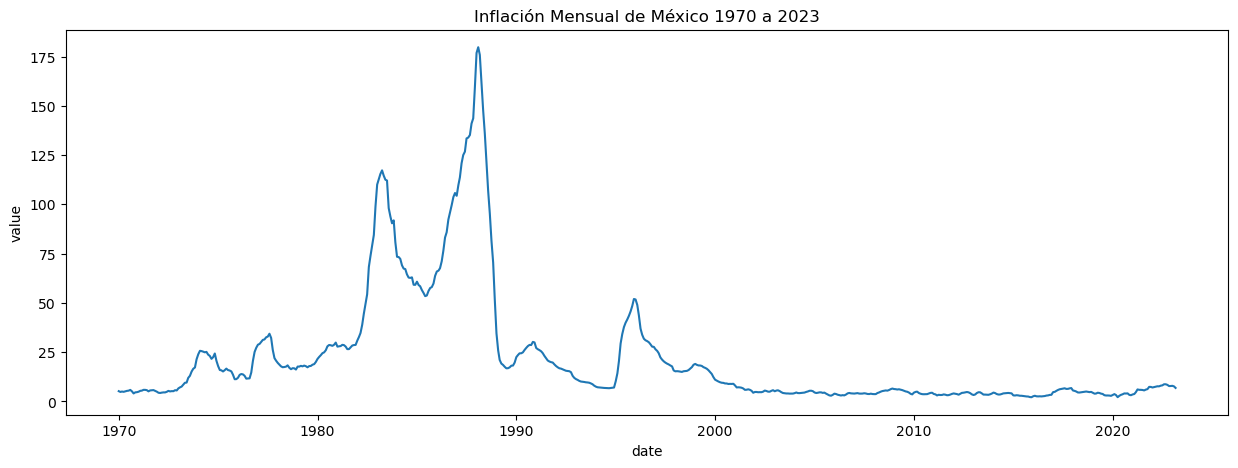

In [4]:
# visualizamos los datos en un grafica
def plot_mx(mx,x,y,title="",xlabel="date",ylabel="value",dpi=100):
    plt.figure(figsize=(15,5), dpi=dpi)
    plt.plot(x,y, color='tab:blue')
    plt.gca().set(title=title,xlabel=xlabel,ylabel=ylabel)
    plt.show()

plot_mx(mx,x=mx.index,y=mx.inflacion_mex,title="Inflación Mensual de México 1970 a 2023")

In [5]:
# Asignamos la frecuencia a la serie, la cual es de frecuencia mensual.
mx = mx.asfreq('MS')

#### Verificamos si la serie es estacionaria

In [53]:
# Para probar si la serie es estacionaria, tenemos la siguiente prueba de hipótesis.
# Prueba de Dickey-Fuller Aumentada.
# H0: Serie no estacionaria.

ADF_test1 = adfuller(mx['inflacion_mex'])

# ADF Test para obtener el valor del p-value
print(f'ADF Statistic: {ADF_test1[0]}')
print(f'p-value: {ADF_test1[1]}')

# El grado de significancia del 5%.
alpha = 0.05

# Regla de decision.
if ADF_test1[1] < alpha:
    print('Se rechaza H0, la serie de tiempo es estacionaria.')
else:
    print('No se rechaza H0, la serie de tiempo es no estacionaria.')

ADF Statistic: -2.8908270656073607
p-value: 0.04642513036210335
Se rechaza H0, la serie de tiempo es estacionaria.


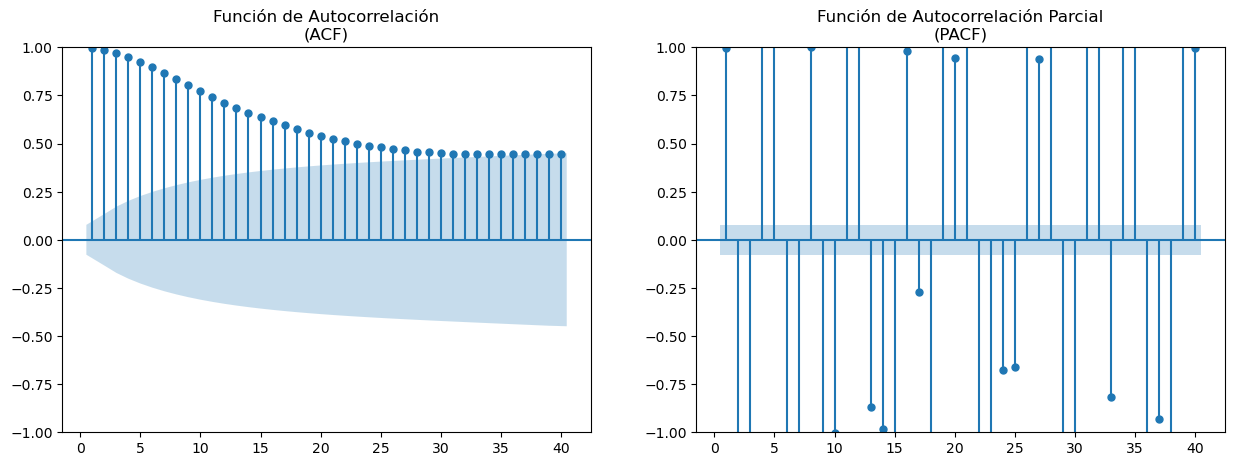

In [58]:
# identificamos qué tipo de proceso es
ig, ax = plt.subplots(1,2, figsize=(15,5))

plot_acf(mx['inflacion_mex'].dropna(), zero=False, lags=40, ax=ax[0],title="Función de Autocorrelación\n(ACF)")
ax[0].set_ylim(-1,1)
plot_pacf(mx['inflacion_mex'].dropna(), zero=False, lags=40, ax=ax[1], title="Función de Autocorrelación Parcial\n(PACF)")
ax[1].set_ylim(-1,1)
plt.show()

La gráfica de autocorrelación nos muestra retrasos positivos lo que nos puede decir que la serie necesita una diferenciación

In [59]:
# aunque la prueba nos dice que la serie es estacionaria aplicaremos una diferencia
mx['inflacion_diferenciado'] = mx['inflacion_mex'].diff()
mx

,inflacion_mex,inflacion_diferenciado
mes,,
1970-01-01,5.20,NaN
1970-02-01,4.81,-0.39
1970-03-01,5.01,0.20
1970-04-01,4.87,-0.14
1970-05-01,5.09,0.22
...,...,...
2022-11-01,7.80,-0.61
2022-12-01,7.82,0.02
2023-01-01,7.91,0.09


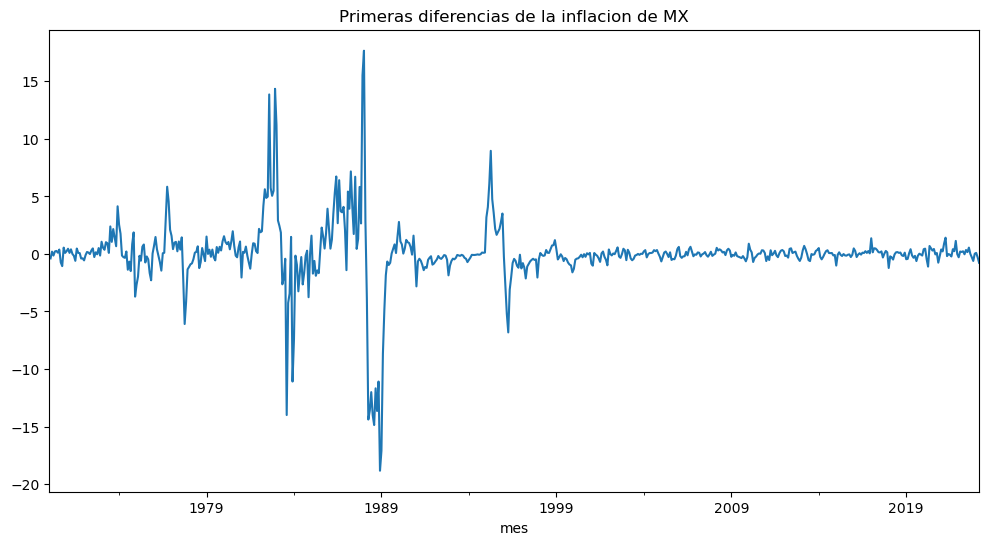

In [60]:
# graficamos
mx['inflacion_diferenciado'].plot(figsize=(12,6))
plt.title("Primeras diferencias de la inflacion de MX")
plt.show()

In [61]:
# Para probar si la serie es estacionaria, tenemos la siguiente prueba de hipótesis.
# Prueba de Dickey-Fuller Aumentada.
# H0: Serie no estacionaria.
ADF_test2 = adfuller(mx['inflacion_diferenciado'].dropna())

# ADF Test para obtener el valor del p-value
print(f'ADF Statistic: {ADF_test2[0]}')
print(f'p-value: {ADF_test2[1]}')

# El grado de significancia del 5%.
alpha = 0.05

# Regla de decision.
if ADF_test2[1] < alpha:
    print('Se rechaza H0, la serie de tiempo es estacionaria.')
else:
    print('No se rechaza H0, la serie de tiempo es no estacionaria.')

ADF Statistic: -6.581293177148572
p-value: 7.502842626815289e-09
Se rechaza H0, la serie de tiempo es estacionaria.


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


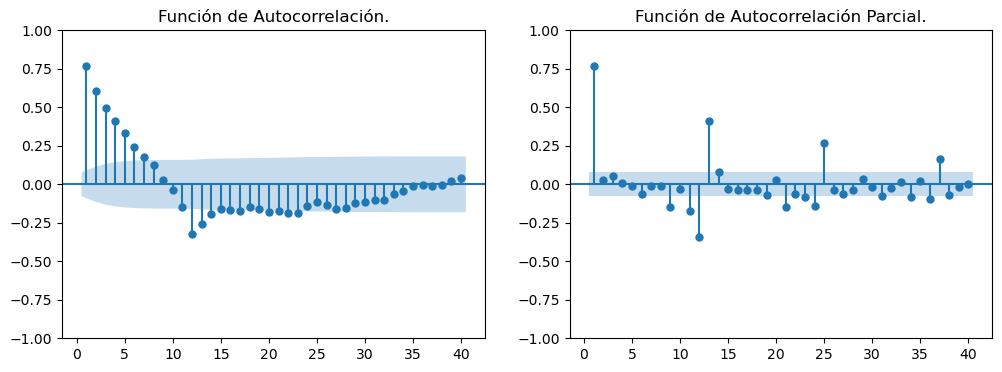

In [62]:
# Graficamos las gráficas de autocorrelación.
ig, ax = plt.subplots(1,2, figsize = (12,4))

# Gráfica ACF
plot_acf(mx['inflacion_diferenciado'].dropna(), zero=False, lags=40, ax = ax[0], title = "Función de Autocorrelación.")
ax[0].set_ylim(-1,1)
# Gráfica PACF
plot_pacf(mx['inflacion_diferenciado'].dropna(), zero=False, lags=40, ax = ax[1], title = "Función de Autocorrelación Parcial.")
ax[1].set_ylim(-1,1)
plt.show()

La gráfica de autocorrelación nos muestra retrasos positivos y negativos por lo que podemos decir que no sobrediferenciamos la serie

#### Estiramos los modelos posibles y elegiremos el mejor

In [71]:
# Estimaremos todos los modelos posibles y guardaremos los estadísticos AIC y BIC.
ic = {}
for ar in range(10):
    for ma in range(10):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(mx['inflacion_diferenciado'].dropna(), order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]
 
ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])
# para utilizar la inflacion_diferenciado tendriamos que cambiar en el order(ar,0,ma)

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 0, MA: 7
AR: 0, MA: 8
AR: 0, MA: 9
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 1, MA: 7
AR: 1, MA: 8
AR: 1, MA: 9
AR: 2, MA: 0
AR: 2, MA: 1


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 2, MA: 2
AR: 2, MA: 3
AR: 2, MA: 4
AR: 2, MA: 5
AR: 2, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 8
AR: 2, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2
AR: 3, MA: 3
AR: 3, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 3, MA: 5
AR: 3, MA: 6
AR: 3, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 8
AR: 3, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\s

AR: 4, MA: 3


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 5


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 8


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 2


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 3


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 5


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 8
AR: 5, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 3


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 5


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 8
AR: 6, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 0
AR: 7, MA: 1
AR: 7, MA: 2


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 7, MA: 3


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 7, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 5


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\s

AR: 7, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 7, MA: 8
AR: 7, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 0
AR: 8, MA: 1
AR: 8, MA: 2


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 8, MA: 3


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 8, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 8, MA: 5


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 8, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 8


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 8, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 0
AR: 9, MA: 1
AR: 9, MA: 2


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 3


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 4


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 5


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 6


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 7


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 8


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 9, MA: 9


C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [72]:
# Imprimimos el dataframe ic, el cual son las combinaciones.
ic

AIC          BIC
AR MA                          
0  0   3134.219514  3143.136191
   1   2781.683615  2795.058630
   2   2671.397131  2689.230485
   3   2626.483709  2648.775401
   4   2607.656715  2634.406745
...            ...          ...
9  5   2468.110521  2539.443934
   6   2471.121147  2546.912898
   7   2434.339397  2514.589486
   8   2386.955996  2471.664423
   9   2388.562256  2477.729022

[100 rows x 2 columns]

In [73]:
# Ordenamos el AIC y BIC de menor a mayor para tener la mejor combinación.

# Según el AIC.
ic.sort_values('AIC', ascending = True).head(3)

AIC          BIC
AR MA                          
8  9   2381.573405  2466.281833
9  8   2386.955996  2471.664423
   9   2388.562256  2477.729022

In [74]:
# Ordenamos el AIC y BIC de menor a mayor para tener la mejor combinación.

# Según el BIC.
ic.sort_values('BIC', ascending = True).head(3)

,,AIC,BIC
AR,MA,,
4,9,2389.159642,2456.034717
5,8,2392.954341,2459.829415
6,8,2389.952220,2461.285632


Según el Criterio de Akaike (AIC), la inflación de México es un modelo ARMA(8,9).

Según el Criterio Bayesiano de Información (BIC), la inflación de México es un modelo ARMA(4,9).

Debido a que no se tuvo que diferenciar la serie, usaremos un modelo ARMA(8, 0, 9) según el Criterio de Akaike.

#### Estimaremos la inflación de México con un modelo ARIMA (8,1,9)

In [96]:
# Estimaremos la inflación de México como un modelo ARIMA(8,1,9)
modelo = ARIMA(mx['inflacion_mex'], order = (8, 1, 9))
resultado = modelo.fit()

# Imprimimos el resultado.
print(resultado.summary())

C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          inflacion_mex   No. Observations:                  639
Model:                 ARIMA(8, 1, 9)   Log Likelihood               -1173.088
Date:                Sun, 07 May 2023   AIC                           2382.177
Time:                        18:42:25   BIC                           2462.427
Sample:                    01-01-1970   HQIC                          2413.330
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1254      0.155      0.808      0.419      -0.179       0.429
ar.L2          0.4682      0.127      3.699      0.000       0.220       0.716
ar.L3          0.0333      0.053      0.634      0.5

Decidimos agregar unos puntos en ar y ma del modelo para ver si esto lo mejoraba en cuanto al AIC

In [97]:
# Realizamos un pronóstico.
resultado.predict('2023-04-01')

2023-04-01    6.269219
Freq: MS, dtype: float64

#### Estimaremos la inflación de México con un modelo ARIMA (9,1,10)

In [98]:
# Estimaremos la inflación de México como un modelo ARIMA(9,1,10)
modelo = ARIMA(mx['inflacion_mex'], order = (9, 1, 10))
resultado = modelo.fit()

# Imprimimos el resultado.
print(resultado.summary())

C:\Users\evanp\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          inflacion_mex   No. Observations:                  639
Model:                ARIMA(9, 1, 10)   Log Likelihood               -1135.127
Date:                Sun, 07 May 2023   AIC                           2310.253
Time:                        18:55:47   BIC                           2399.420
Sample:                    01-01-1970   HQIC                          2344.868
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7528      0.043     17.435      0.000       0.668       0.837
ar.L2         -0.9732      0.043    -22.791      0.000      -1.057      -0.889
ar.L3          0.7046      0.052     13.562      0.0

In [99]:
# Realizamos un pronóstico.
resultado.predict('2023-04-01')

2023-04-01    6.224162
Freq: MS, dtype: float64

<b>Nuestra estimación estaría entre 6.26% y 6.24% según nuestro modelo </b> <br>
Por lo que recabamos información de otras fuentes para tomar la mejor decisión y elegiremos un pronóstico de <b>6.24%</b>